Day 3 Home work

# 房价预测-单维度版本

In [ ]:
import random

In [2]:
from collections import defaultdict

In [3]:
import numpy as np

## 节点基类

In [5]:
# 网络的基类
class Node:
    def __init__(self,inputs=[]):
        self.inputs = inputs
        self.ouputs = []
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes
        self.value = None
        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        
    def forward(self):
        """
        前向传播
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        """
        # 这是虚类,不能被调用到
        raise NotImplemented
    
    def backward(self):
        
        raise NotImplemented

node = Node()
print(node)

In [6]:
# 网络的基类,更完美的版本,多了 __repr__,可以打印名字
class Node:
    def __init__(self, inputs=[], name=None, is_trainable=True):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.is_trainable = is_trainable
        
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        
        self.gradients = {}
        
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError
    
    def __repr__(self):
        return self.name
    
node = Node(name='try')
print(node)

try


## 由Node派生各种网络节点

In [7]:
class Placeholder(Node):
    def __init__(self, name, is_trainable=True):
        Node.__init__(self, name=name, is_trainable=is_trainable)
        
    def forward(self, value=None):
        if value is not None: self.value = value
    
    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            self.gradients[self] = n.gradients[self] * 1

class Linear(Node):
    # weight,bias,name 都是Placeholder数据类型
    def __init__(self, x=None, weigth=None, bias=None, name=None, is_trainable=False):
        Node.__init__(self, [x, weigth, bias], name=name, is_trainable=is_trainable)
        
    def forward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        self.value = k.value * x.value + b.value
        
    def backward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[k] = grad_cost * x.value
            
            self.gradients[x] = grad_cost * k.value
            
            self.gradients[b] = grad_cost * 1
    
        
class Sigmoid(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = self.inputs[0]
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x.value)
        
    def partial(self):
        return self._sigmoid(self.x.value) * (1 - self._sigmoid(self.x.value))
    
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * self.partial() 
    #    print(self.gradients)
    
    
class Relu(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = x
        
    def forward(self):
        self.value = self.x.value * (self.x.value > 0)
        
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            # 反向传播时,由于Relu是分段函数,因此也是分段求导数
            # 当x < 0 的时候, 梯度为0
            self.gradients[self.x] = grad_cost * (self.x.value > 0) 
        

class L2_LOSS(Node):
    def __init__(self, y, y_hat, name=None, is_trainable=False):
        Node.__init__(self, [y, y_hat], name=name, is_trainable=is_trainable)
        self.y = y
        self.y_hat = y_hat
        
    def forward(self):        
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.value = np.mean((y_v - yhat_v) ** 2)
        
    def backward(self):
        # 1/n sum (y- yhat)**2
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.gradients[self.y] = 2 * np.mean((y_v - yhat_v))
        self.gradients[self.y_hat] = -2 * np.mean((y_v - yhat_v))
     #   print(self.gradients)  

## 计算图

In [8]:
def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))
            
            visited_next = [node]
            if len(graph) == 1:  visited_next += graph[node]
                
            graph.pop(node)
            sorted_node += visited_next

            for _, links in graph.items():
                if node in links: links.remove(node)
        else:
            break
        
    return sorted_node

In [9]:
def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)

In [10]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

## 定义整个计算图的前向计算和反向传播

In [12]:
def forward(graph_order, monitor=False):
    for node in graph_order:
        if monitor: print('forward compuiting -- {}'.format(node))
        node.forward()
        
def backward(graph_order, monitor=False):
    for node in graph_order[::-1]:
        if monitor: print('backward computing -- {}'.format(node))
        node.backward()

In [13]:
def run_one_epoch(graph_order, monitor=False):
    forward(graph_order, monitor)
    backward(graph_order, monitor)

In [14]:
def optimize(graph, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in graph:
        if t.is_trainable:
            t.value += -1 * learning_rate * t.gradients[t]

## 房价预测-单维版本

In [15]:
from sklearn.datasets import load_boston

## 获取数据

In [17]:
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [18]:
data = load_boston()
X_, y_ = data['data'], data['target'] # X_ 为特征值, y_为房价
X_rm = X_[:, 5]     # Room ,每一行的第5列

# 初始化参数
w1_, b1_ = np.random.normal(), np.random.normal()
w2_, b2_ = np.random.normal(), np.random.normal()
w3_, b3_ = np.random.normal(), np.random.normal()


X, y = Placeholder(name='X', is_trainable=False), Placeholder(name='y', is_trainable=False)
w1, b1 = Placeholder(name='w1'), Placeholder(name='b1')
w2, b2 = Placeholder(name='w2'), Placeholder(name='b2')

# build model
output1 = Linear(X, w1, b1, name='linear-01')
output2 = Sigmoid(output1, name='activation')
#output2 = Relu(output1, name='activation')
y_hat = Linear(output2, w2, b2, name='y_hat')
cost = L2_LOSS(y, y_hat, name='cost')

feed_dict = {
    X: X_rm,
    y: y_,
    w1: w1_,
    w2: w2_,
    b1: b1_,
    b2: b2_,
}

graph_sort = topological_sort_feed_dict(feed_dict)

## 训练

In [19]:
epoch = 1000

batch_num = len(X_rm)

learning_rate = 1e-3

losses = []

for e in tqdm_notebook(range(epoch)):
    loss = 0
    
    for b in range(batch_num):
        index = np.random.choice(range(len(X_rm)))
        X.value = X_rm[index]
        y.value = y_[index]
    
        run_one_epoch(graph_sort, monitor=False)
    
        optimize(graph_sort, learning_rate)
        
        loss += cost.value

    losses.append(loss / batch_num)

/home/gang/anaconda3/envs/YOLO/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


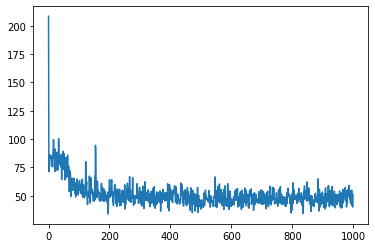

In [20]:
plt.plot(losses)

## 预测

In [21]:
def predicate(x, graph):
    X.value = x
    forward(graph)
    return y_hat.value

In [22]:
predicate(7, graph_sort)

22.376978887774975

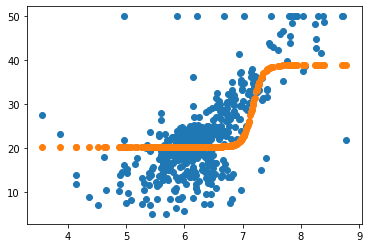

In [23]:
plt.scatter(X_rm, y_) # 实际的房价
plt.scatter(X_rm, [predicate(x, graph_sort) for x in X_rm]) #拟合出来的房价

# 房价预测,多维版本

## 定义网络

In [24]:
import numpy as np
import random

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Placeholder(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N

In [25]:
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

        
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias # 因为是多维向量,所以乘法改dot()
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        


            

In [26]:
def forward_and_backward(graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

from collections import defaultdict


def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)


def optimize(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]
        

In [28]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [29]:
losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
#         forward_and_backward(_, graph) # set output node not important.
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 1, Loss: 181.189
Epoch: 101, Loss: 6.751
Epoch: 201, Loss: 6.272
Epoch: 301, Loss: 4.925
Epoch: 401, Loss: 5.252
Epoch: 501, Loss: 4.648
Epoch: 601, Loss: 4.033
Epoch: 701, Loss: 4.906
Epoch: 801, Loss: 4.098
Epoch: 901, Loss: 3.361
Epoch: 1001, Loss: 3.742
Epoch: 1101, Loss: 3.560
Epoch: 1201, Loss: 3.632
Epoch: 1301, Loss: 3.746
Epoch: 1401, Loss: 3.656
Epoch: 1501, Loss: 3.661
Epoch: 1601, Loss: 2.930
Epoch: 1701, Loss: 3.416
Epoch: 1801, Loss: 2.981
Epoch: 1901, Loss: 3.061
Epoch: 2001, Loss: 3.701
Epoch: 2101, Loss: 3.314
Epoch: 2201, Loss: 3.011
Epoch: 2301, Loss: 3.573
Epoch: 2401, Loss: 3.622
Epoch: 2501, Loss: 3.140
Epoch: 2601, Loss: 3.323
Epoch: 2701, Loss: 3.286
Epoch: 2801, Loss: 3.230
Epoch: 2901, Loss: 3.319
Epoch: 3001, Loss: 3.213
Epoch: 3101, Loss: 3.729
Epoch: 3201, Loss: 3.495
Epoch: 3301, Loss: 3.610
Epoch: 3401, Loss: 3.387
Epoch: 3501, Loss: 3.231
Epoch: 3601, Loss: 3.144
Epoch: 3701, Loss: 2.730
Epoch: 3801, Loss: 4.062
Epoch: 3901, Loss: 3.251
Epoch: 400